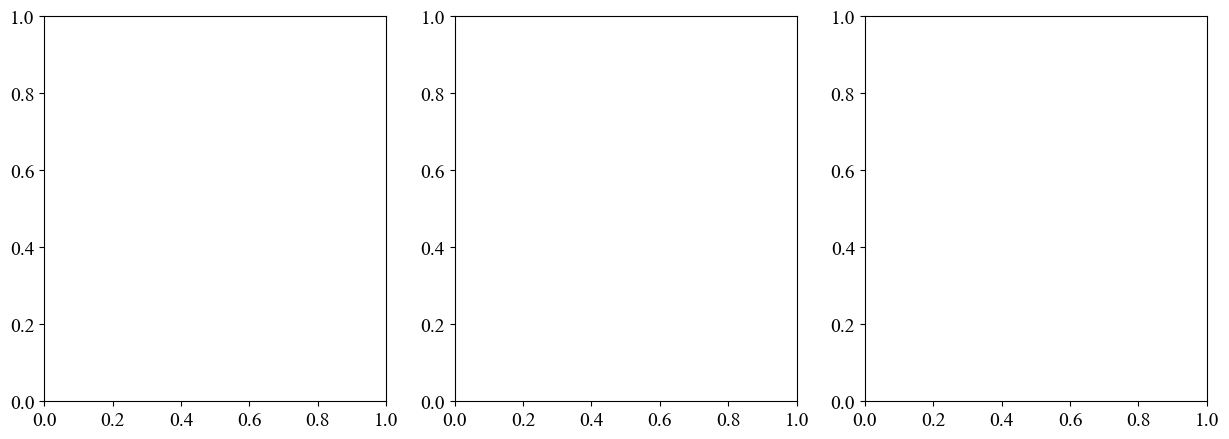

In [14]:
custom_color_mapping = {
    'Fire': 'orangered',
    'Storm': 'royalblue',
    'Biotic-dieback': 'gold',
    'Biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'Drought-dieback': 'darkkhaki',
    'Tree-logging': 'cadetblue'  # Light blue/grey
}
def hist(a, ax, perc, xlim=3500e3):
    # Get the unique classes
    unique_classes = a['class'].unique()

    # Plotting bars for each class and adding the counts as text inside the bars
    for i, c in enumerate(unique_classes):
        total_count = (a['class'] == c).sum()
        # multi_count = ((a['class'] == c) & (a['dataset'] == 'multi')).sum()
        
        ax.barh(i, total_count, color=custom_color_mapping[c], alpha=1, label="Senf&Seidl" if c == unique_classes[0] else "")
        # ax.barh(i, multi_count, color=custom_color_mapping[c], label="Attributed with multiple sources" if c == unique_classes[0] else "")
        
        # Displaying the count as text inside the bars
        ax.text(max(total_count, xlim/10), i, str(total_count), va='center', ha='center', color='black', fontsize=10)
        # ax.text(multi_count / 2, i, str(multi_count), va='bottom', ha='center', color='black', fontsize=10)

    # Setting labels and title
    ax.set_yticks(range(len(unique_classes)))
    ax.set_yticklabels(unique_classes, rotation=45)

    #DROP SPINES
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Removing the x-axis for a cleaner look
    ax.axes.get_xaxis().set_visible(False)
    ax.set_xlim(0, xlim)
    ax.set_title(f"Attribution of {perc :.1%} of events")

import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
import numpy as np
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def triad(axes, data, perc):
    data_ = data[ data['class'] != 'Other' ].copy()
    data_['p'] = sigmoid(data['p'])
    data_['area'] = data.geometry.area / 1e6

    # Sample code to generate the heatmap based on the provided requirements:

    # Split the 'specie' column into individual species
    specie_split = data_['essence'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).rename('individual_specie')

    # Join the split species back to the main dataframe
    data_expanded = data_.join(specie_split)

    # Get the top 5 species by frequency
    top_5_species = data_expanded['individual_specie'].value_counts().head(5).index.tolist()

    # Filter the dataset to only consider the top 5 species
    filtered_data = data_expanded[data_expanded['individual_specie'].isin(top_5_species)]

    # Sum the 'area' values for each combination of 'class' and individual 'specie' for the heatmap
    heatmap_area_data_filtered = filtered_data.groupby(['class', 'individual_specie'])['area'].sum().unstack(fill_value=0)


    # Plot the heatmap
    sns.heatmap(heatmap_area_data_filtered, ax=axes[0], cmap="crest", cbar=False, annot=True, fmt='.1f', square=True)
    axes[0].set_ylabel(None)
    axes[0].set_xlabel(None)
    axes[0].tick_params(left=False)
    axes[0].set_title('Area (km²)')

    # Plot the dual violin plots for spread and probability
    sns.violinplot(data=data_, x='class', y='p', ax=axes[1], density_norm='width', palette=custom_color_mapping, inner="quartile")
    axes[1].set_xlabel(None)
    #delete all spines
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['bottom'].set_visible(False)
    axes[1].spines['left'].set_visible(False)
    axes[1].tick_params(axis='x', rotation=45)
    #horinzontal grid lines
    axes[1].grid(axis='y', color='gray', linestyle='dashed', alpha=0.5)
    axes[1].set_ylim(0.35, 0.8)
    axes[1].set_title("Attribution probability")

    # Plot the pie chart
    hist(data_, axes[2], perc)

In [42]:
import geopandas as gpd 

year = 2000
data = gpd.read_parquet(f'../data/results/attribution_{year}.parquet').set_crs('epsg:2154')

senfseidl = gpd.read_parquet('../data/processed_datasets/SenfSeidl_joined_EPSG4326_FR.parquet').to_crs('epsg:2154')
senfseidl.year = senfseidl.year.astype(int)

number_to_class = {
    1:'Storm,Biotic', 
    2:'Fire',
    3:'Other'
}

senfseidl['class'] = senfseidl['cause'].map(number_to_class)
senf_seidl_col = ['year', 'geometry', 'class', 'tree_type', 'essence']
senfseidl = senfseidl[senf_seidl_col]
senfseidl.drop_duplicates(inplace=True)
senfseidl.dropna(inplace=True)
data_ss = senfseidl[senfseidl.year == year]

In [9]:
a = data_.reset_index().iloc[:10000][['class', 'p', 'spread', 'essence', 'area']].rename(columns={'essence':'specie'})
a.reset_index(inplace=True, drop=True)
a['class'] = ['Biotic-dieback' for x in range(3000)] + ['Fire' for x in range(1000)] + ['Storm' for x in range(6000)]
import random
a['spread'] = [random.random() for x in range(10000)]
a['dataset'] = [random.choice(['ref', 'multi']) for x in range(10000)]
a['p'] = sigmoid(data['p'])
a.to_csv('attribution_chatgpt.csv')

In [10]:
a

,class,p,spread,specie,area,dataset
0,Biotic-dieback,0.451471,0.500015,beech,0.006311,ref
1,Biotic-dieback,0.461291,0.139853,beech,0.004508,ref
2,Biotic-dieback,0.461291,0.638957,beech,0.004508,multi
3,Biotic-dieback,0.451471,0.302722,beech,0.001803,ref
4,Biotic-dieback,0.451471,0.492993,beech,0.002705,multi
...,...,...,...,...,...,...
9995,Storm,0.461291,0.431157,"nr,maritime pine",0.036911,ref
9996,Storm,0.461291,0.467048,"poplar,maritime pine",0.002701,ref
9997,Storm,0.461291,0.869133,"poplar,maritime pine",0.005402,multi
9998,Storm,0.451471,0.034602,maritime pine,0.000900,ref


In [54]:
data['class'].value_counts().max()

300515

NameError: name 'a' is not defined

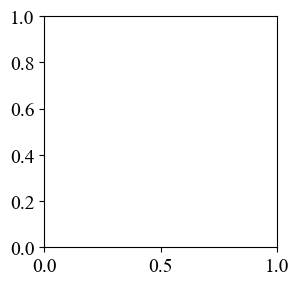

In [8]:
fig, ax = plt.subplots(figsize=(3, 3))
custom_color_mapping = {
    'Fire': 'orangered',
    'Storm': 'royalblue',
    'Biotic-dieback': 'gold',
    'Biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'Drought-dieback': 'darkkhaki',
    'Tree-logging': 'cadetblue'  # Light blue/grey
}

def hist(a, ax, perc, xlim=300e3):
    # Get the unique classes
    unique_classes = a['class'].unique()

    # Plotting bars for each class and adding the counts as text inside the bars
    for i, c in enumerate(unique_classes):
        total_count = (a['class'] == c).sum()
        # multi_count = ((a['class'] == c) & (a['dataset'] == 'multi')).sum()
        
        ax.barh(i, total_count, color=custom_color_mapping[c], alpha=1, label="Senf&Seidl" if c == unique_classes[0] else "")
        # ax.barh(i, multi_count, color=custom_color_mapping[c], label="Attributed with multiple sources" if c == unique_classes[0] else "")
        
        # Displaying the count as text inside the bars
        ax.text(max(total_count, xlim/10), i, str(total_count), va='center', ha='center', color='black', fontsize=10)
        # ax.text(multi_count / 2, i, str(multi_count), va='bottom', ha='center', color='black', fontsize=10)

    # Setting labels and title
    ax.set_yticks(range(len(unique_classes)))
    ax.set_yticklabels(unique_classes, rotation=45)

    #DROP SPINES
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Removing the x-axis for a cleaner look
    ax.axes.get_xaxis().set_visible(False)
    ax.set_xlim(0, xlim)
    ax.set_title(f"Attribution of {perc :.1%} of events")

hist(a, ax, perc=0.87)


In [67]:
a.shape[0] / 12000

0.8333333333333334

In [18]:
data.columns

Index(['year', 'geometry', 'tree_type', 'essence', 'index_ref', 'class', 'p',
       'spread'],
      dtype='object')

In [3]:
data['class'].value_counts()

class
Storm             300515
Biotic-dieback     20017
Fire                1946
Other                  2
Name: count, dtype: Int64

<Axes: xlabel='individual_specie', ylabel='class'>

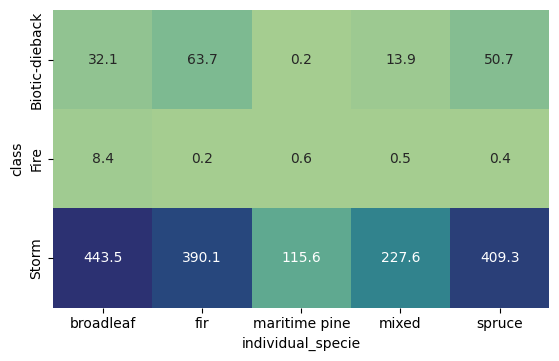

In [6]:
import seaborn as sns
data_ = data[ data['class'] != 'Other' ].copy()
import numpy as np
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

data_['p'] = sigmoid(data['p'])
data_['area'] = data.geometry.area / 1e6

# Sample code to generate the heatmap based on the provided requirements:

# Split the 'specie' column into individual species
specie_split = data_['essence'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).rename('individual_specie')

# Join the split species back to the main dataframe
data_expanded = data_.join(specie_split)

# Get the top 5 species by frequency
top_5_species = data_expanded['individual_specie'].value_counts().head(5).index.tolist()

# Filter the dataset to only consider the top 5 species
filtered_data = data_expanded[data_expanded['individual_specie'].isin(top_5_species)]

# Sum the 'area' values for each combination of 'class' and individual 'specie' for the heatmap
heatmap_area_data_filtered = filtered_data.groupby(['class', 'individual_specie'])['area'].sum().unstack(fill_value=0)

sns.heatmap(heatmap_area_data_filtered, cmap="crest", cbar=False, annot=True, fmt='.1f', square=True)

In [78]:
# Count the occurrences of each disturbance class for pie chart
pie_data = data_['class'].value_counts()

# Exclude those with zero entries
pie_data = pie_data[pie_data > 0]

pie_data

class
Storm             249379
Biotic-dieback     17139
Fire                1279
Name: count, dtype: Int64

/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


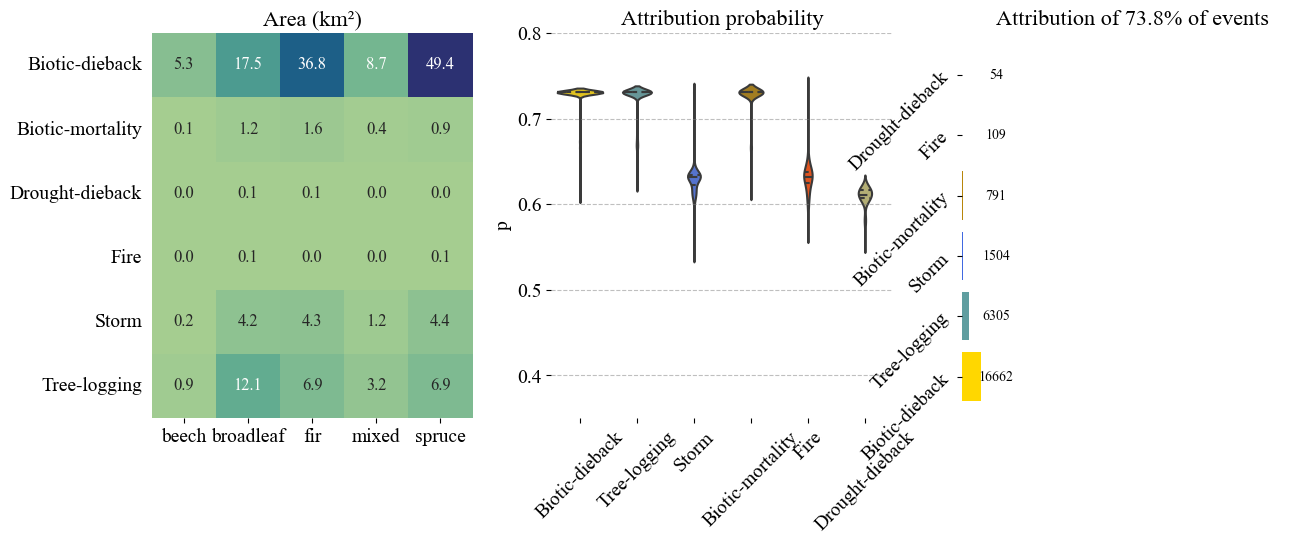

In [88]:
custom_color_mapping = {
    'Fire': 'orangered',
    'Storm': 'royalblue',
    'Biotic-dieback': 'gold',
    'Biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'Drought-dieback': 'darkkhaki',
    'Tree-logging': 'cadetblue'  # Light blue/grey
}

import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
import numpy as np
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def triad(axes, data, perc):
    data_ = data[ data['class'] != 'Other' ].copy()
    data_['p'] = sigmoid(data['p'])
    data_['area'] = data.geometry.area / 1e6

    # Sample code to generate the heatmap based on the provided requirements:

    # Split the 'specie' column into individual species
    specie_split = data_['essence'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).rename('individual_specie')

    # Join the split species back to the main dataframe
    data_expanded = data_.join(specie_split)

    # Get the top 5 species by frequency
    top_5_species = data_expanded['individual_specie'].value_counts().head(5).index.tolist()

    # Filter the dataset to only consider the top 5 species
    filtered_data = data_expanded[data_expanded['individual_specie'].isin(top_5_species)]

    # Sum the 'area' values for each combination of 'class' and individual 'specie' for the heatmap
    heatmap_area_data_filtered = filtered_data.groupby(['class', 'individual_specie'])['area'].sum().unstack(fill_value=0)


    # Plot the heatmap
    sns.heatmap(heatmap_area_data_filtered, ax=axes[0], cmap="crest", cbar=False, annot=True, fmt='.1f', square=True)
    axes[0].set_ylabel(None)
    axes[0].set_xlabel(None)
    axes[0].tick_params(left=False)
    axes[0].set_title('Area (km²)')

    # Plot the dual violin plots for spread and probability
    sns.violinplot(data=data_, x='class', y='p', ax=axes[1], density_norm='width', palette=custom_color_mapping, inner="quartile")
    axes[1].set_xlabel(None)
    #delete all spines
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['bottom'].set_visible(False)
    axes[1].spines['left'].set_visible(False)
    axes[1].tick_params(axis='x', rotation=45)
    #horinzontal grid lines
    axes[1].grid(axis='y', color='gray', linestyle='dashed', alpha=0.5)
    axes[1].set_ylim(0.35, 0.8)
    axes[1].set_title("Attribution probability")

    # Plot the pie chart
    hist(data_, axes[2], perc)

triad(axes, data, 0.738)


In [10]:
cx.providers.Stamen.Watercolor.url = 'https://tiles.stadiamaps.com/tiles/stamen_watercolor/{z}/{x}/{y}.jpg'

In [132]:
#stamen now on stadia : https://docs.stadiamaps.com/guides/migrating-from-stamen-map-tiles/
from xyzservices import TileProvider 

watercolor = TileProvider(
    name = 'Stamen Watercolor',
    url = 'https://tiles.stadiamaps.com/tiles/stamen_watercolor/{z}/{x}/{y}.jpg',
    attribution = None
)

line = watercolor = TileProvider(
    name = 'Stamen Lines',
    url = 'https://tiles.stadiamaps.com/tiles/stamen_toner_lines/{z}/{x}/{y}{r}.png',
    attribution = None
)

cx.providers.Stamen.Watercolor.url = 'https://tiles.stadiamaps.com/tiles/stamen_watercolor/{z}/{x}/{y}.jpg'
cx.providers.Stamen.TonerLines.url = 'https://tiles.stadiamaps.com/tiles/stamen_toner_lines/{z}/{x}/{y}{r}.png'


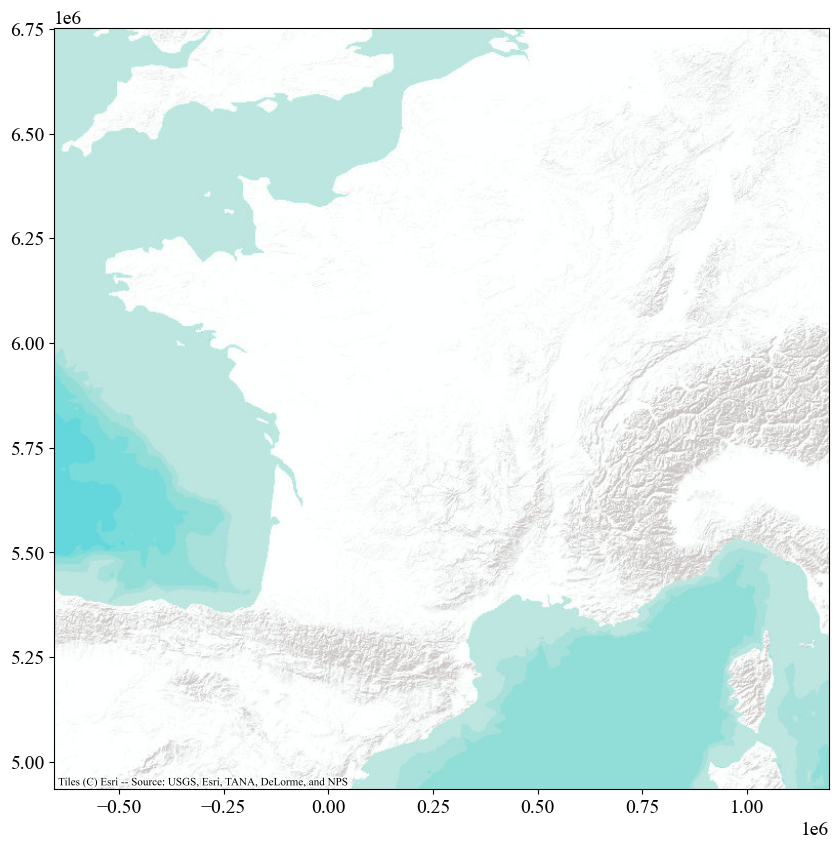

In [161]:


fig, ax = plt.subplots(figsize=(10, 10))
df.plot(ax=ax, color='none', edgecolor='none', linewidth=0)
# cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(ax, source=cx.providers.Esri.WorldTerrain)


In [7]:
from matplotlib.ticker import MultipleLocator, FuncFormatter
import math

# Define a function to convert Web Mercator to lat/lon
def web_mercator_to_lat_lon(val, pos=None, is_lat=True):
    if is_lat:
        return "{:.2f}°".format(math.degrees(2 * math.atan(math.exp(val / 6378137.0)) - math.pi/2))
    else:
        return "{:.2f}°".format(val / (6378137.0) * 57.2957795)


In [ ]:
import geopandas as gpd 
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
from utils import pol_from_points
from matplotlib.ticker import MultipleLocator, FuncFormatter
import math
from tqdm import tqdm

SAVE = True
v = 1 
import os
os.makedirs('../figures', exist_ok=True)

# Set global font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Set global font size
plt.rcParams['font.size'] = 12  # Adjust as needed

# Additional font size settings
plt.rcParams['axes.labelsize'] = 14  # Font size for x and y labels
plt.rcParams['axes.titlesize'] = 16  # Font size for subplot titles
plt.rcParams['xtick.labelsize'] = 14  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y tick labels

#dflim
epsg = 3857
data = gpd.read_parquet(f'../data/results/attribution_2000.parquet').set_crs('epsg:2154')
gdf_web_mercator = data.to_crs(epsg=epsg)
minx, miny, maxx, maxy = gdf_web_mercator.geometry.buffer(50000).total_bounds
#build GeoDataFrame from the bounds
df_lim = gpd.GeoDataFrame({'geometry': pol_from_points((minx, miny, maxx, maxy))}, index=[0], crs=f'epsg:{epsg}')


#Senf&Seidl
senfseidl = gpd.read_parquet('../data/processed_datasets/SenfSeidl_joined_EPSG4326_FR.parquet').to_crs('epsg:2154')
senfseidl.year = senfseidl.year.astype(int)

number_to_class = {
    1:'Storm,Biotic', 
    2:'Fire',
    3:'Other'
}

senfseidl['class'] = senfseidl['cause'].map(number_to_class)
senf_seidl_col = ['year', 'geometry', 'class', 'tree_type', 'essence']
senfseidl = senfseidl[senf_seidl_col]
senfseidl.drop_duplicates(inplace=True)
senfseidl.dropna(inplace=True)


for year in tqdm(range(1986,2021)):

  data = gpd.read_parquet(f'../data/results/attribution_{year}_v{v}.parquet').set_crs('epsg:2154')
  #map class Drought to Drought-dieback
  data['class'] = data['class'].replace({'Drought':'Drought-dieback'})
  data_ss = senfseidl[senfseidl.year == year]
  perc = data.shape[0] / data_ss.shape[0]

  # Setup the figure and axes using GridSpec
  fig = plt.figure(figsize=(15, 14))
  gs = GridSpec(3, 3, figure=fig)

  # Define colors for each class
  custom_color_mapping = {
      'Fire': 'orangered',
      'Storm': 'royalblue',
      'Biotic-dieback': 'gold',
      'Biotic-mortality': 'darkgoldenrod',  # Yellow-brown
      'Drought-dieback': 'darkkhaki',
      'Tree-logging': 'cadetblue'  # Light blue/grey
  }
  class_names = custom_color_mapping.keys()
  data.year = data.year.astype(int)
  data = data[ data.geometry.area > 500 ]
  gdf_web_mercator = data.to_crs(epsg=epsg)

  # minx, miny, maxx, maxy = gdf_web_mercator.geometry.buffer(50000).total_bounds
  # #build GeoDataFrame from the bounds
  # df = gpd.GeoDataFrame({'geometry': pol_from_points((minx, miny, maxx, maxy))}, index=[0], crs=f'epsg:{epsg}')

  # Plot point clouds for each class in the first two rows
  for idx, class_name in enumerate(sorted(class_names)):
      row = idx // 3 
      col = idx % 3
      print(row, col)

      #get gdf and simplify 
      gdf = gdf_web_mercator[ (gdf_web_mercator['class'] == class_name) ]
      gdf.geometry = gdf.geometry.simplify(1000)


      ax = fig.add_subplot(gs[row, col])

      df_lim.plot(ax=ax, color='none', edgecolor='none', linewidth=0)
      gdf[gdf['class'] == class_name].plot(ax=ax, color=custom_color_mapping[class_name], edgecolor=custom_color_mapping[class_name], alpha=1, linewidth=0.5)

      # Adding basemap with contextily
      cx.add_basemap(ax, crs=df.crs.to_string(), attribution=False, source=cx.providers.CartoDB.PositronNoLabels, zoom=5, alpha=0.8)
      # cx.add_basemap(ax, crs=df.crs.to_string(), attribution=False, source=line, zoom=5, alpha=0.4)
      
  
      ax.set_title(class_name)
      ax.axis('equal')
      ax.grid(True, linestyle='--')  # Add grid

      # # Setting the same extents for all plots
      ax.set_xlim((minx, maxx))
      ax.set_ylim((miny, maxy))


      if row < 2:
          
          # Using MultipleLocator to set tick locations
          ax.xaxis.set_major_locator(MultipleLocator(0.5 * 10**6))
          ax.yaxis.set_major_locator(MultipleLocator(0.5 * 10**6))

          # Using FuncFormatter to convert tick labels to lat/lon
          ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: web_mercator_to_lat_lon(val, pos, is_lat=False)))
          ax.yaxis.set_major_formatter(FuncFormatter(web_mercator_to_lat_lon))
          
          ax.annotate(year, xy=(0.5, 0), xytext=(0, 10),
                  xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline', fontsize=12, color='black', fontname='Times New Roman')
      
          ax.spines['right'].set_visible(False)
          ax.spines['top'].set_visible(False)




  ax1 = fig.add_subplot(gs[2, 0])
  ax2 = fig.add_subplot(gs[2, 1])
  ax3 = fig.add_subplot(gs[2, 2])

  triad([ax1, ax2, ax3], data, perc)
  # # Plot the heatmap
  # sns.heatmap(heatmap_area_data_filtered, ax=ax1, cmap="crest", cbar=False, annot=True, fmt='.1f', square=True)
  # ax1.set_ylabel(None)
  # ax1.set_xlabel(None)
  # ax1.tick_params(left=False)
  # ax1.set_title('Area (km²)')

  # # Plot the dual violin plots for spread and probability
  # sns.violinplot(data=data_, x='class', y='p', ax=ax2, density_norm='width', palette=custom_color_mapping, inner="quartile")
  # ax2.set_xlabel(None)
  # #delete all spines
  # ax2.spines['right'].set_visible(False)
  # ax2.spines['top'].set_visible(False)
  # ax2.spines['bottom'].set_visible(False)
  # ax2.spines['left'].set_visible(False)
  # ax2.tick_params(axis='x', rotation=45)
  # #horinzontal grid lines
  # ax2.grid(axis='y', color='gray', linestyle='dashed', alpha=0.5)

  # # Plot the pie chart
  # ax3.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=140, colors=[custom_color_mapping[x] for x in pie_data.index])

  plt.tight_layout()
  plt.show()
  if SAVE:
    fig.savefig(f'../figures/{year}_v{v}.png', dpi=200)



TROP D'INFLUENCE DE DFDE, enlever les doublons avec les commentaires differents, si trop de doublon + trop de poids. 
Calculer la distance temporelle en jours et pas en année. 

# ALL years

0 0


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0 1


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0 2


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


1 0


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


1 1


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


1 2


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arthurcalvi/Venv/DiAtDaJo/lib/

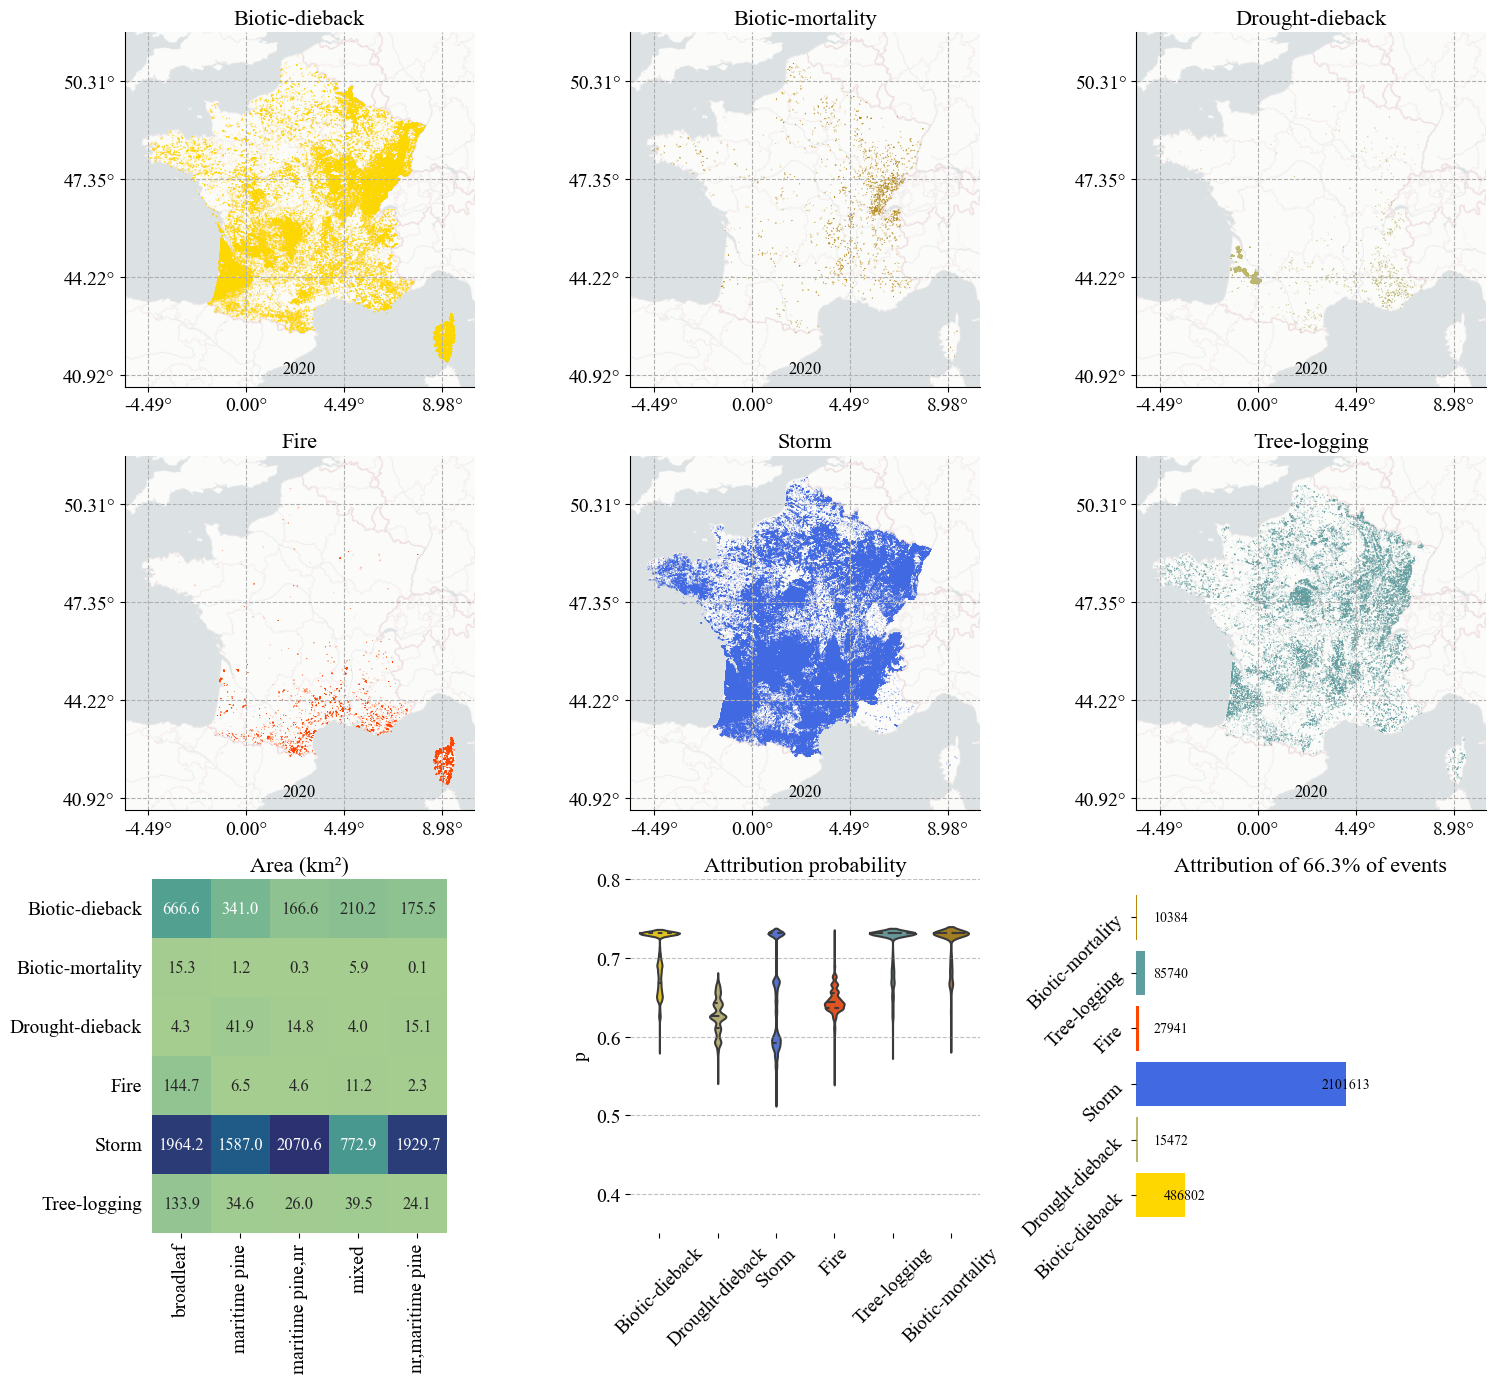

In [16]:
import geopandas as gpd 
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
from utils import pol_from_points
from matplotlib.ticker import MultipleLocator, FuncFormatter
import math
from tqdm import tqdm

SAVE = True
v = 1 
import os
os.makedirs('../figures', exist_ok=True)

# Set global font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Set global font size
plt.rcParams['font.size'] = 12  # Adjust as needed

# Additional font size settings
plt.rcParams['axes.labelsize'] = 14  # Font size for x and y labels
plt.rcParams['axes.titlesize'] = 16  # Font size for subplot titles
plt.rcParams['xtick.labelsize'] = 14  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y tick labels

# #dflim
# epsg = 3857
# data = gpd.read_parquet(f'../data/results/attribution_2000.parquet').set_crs('epsg:2154')
# gdf_web_mercator = data.to_crs(epsg=epsg)
# minx, miny, maxx, maxy = gdf_web_mercator.geometry.buffer(50000).total_bounds
# #build GeoDataFrame from the bounds
# df_lim = gpd.GeoDataFrame({'geometry': pol_from_points((minx, miny, maxx, maxy))}, index=[0], crs=f'epsg:{epsg}')


# #Senf&Seidl
# senfseidl = gpd.read_parquet('../data/processed_datasets/SenfSeidl_joined_EPSG4326_FR.parquet').to_crs('epsg:2154')
# senfseidl.year = senfseidl.year.astype(int)

# number_to_class = {
#     1:'Storm,Biotic', 
#     2:'Fire',
#     3:'Other'
# }

# senfseidl['class'] = senfseidl['cause'].map(number_to_class)
# senf_seidl_col = ['year', 'geometry', 'class', 'tree_type', 'essence']
# senfseidl = senfseidl[senf_seidl_col]
# senfseidl.drop_duplicates(inplace=True)
# senfseidl.dropna(inplace=True)
# import pandas as pd 

# data = []
# for year in tqdm(range(1986,2021)):

#   data_ = gpd.read_parquet(f'../data/results/attribution_{year}_v{v}.parquet').set_crs('epsg:2154')
#   #map class Drought to Drought-dieback
#   data_['class'] = data_['class'].replace({'Drought':'Drought-dieback'})
#   data.append(data_)

# data = gpd.GeoDataFrame(pd.concat(data, ignore_index=True), crs='epsg:2154')
# perc = data.shape[0] / senfseidl.shape[0]

# Setup the figure and axes using GridSpec
fig = plt.figure(figsize=(15, 14))
gs = GridSpec(3, 3, figure=fig)

# Define colors for each class
custom_color_mapping = {
    'Fire': 'orangered',
    'Storm': 'royalblue',
    'Biotic-dieback': 'gold',
    'Biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'Drought-dieback': 'darkkhaki',
    'Tree-logging': 'cadetblue'  # Light blue/grey
}
class_names = custom_color_mapping.keys()
data.year = data.year.astype(int)
data = data[ data.geometry.area > 500 ]
gdf_web_mercator = data.to_crs(epsg=epsg)

# minx, miny, maxx, maxy = gdf_web_mercator.geometry.buffer(50000).total_bounds
# #build GeoDataFrame from the bounds
# df = gpd.GeoDataFrame({'geometry': pol_from_points((minx, miny, maxx, maxy))}, index=[0], crs=f'epsg:{epsg}')

# Plot point clouds for each class in the first two rows
for idx, class_name in enumerate(sorted(class_names)):
    row = idx // 3 
    col = idx % 3
    print(row, col)

    #get gdf and simplify 
    gdf = gdf_web_mercator[ (gdf_web_mercator['class'] == class_name) ]
    gdf.geometry = gdf.geometry.simplify(1000)


    ax = fig.add_subplot(gs[row, col])

    df_lim.plot(ax=ax, color='none', edgecolor='none', linewidth=0)
    gdf[gdf['class'] == class_name].plot(ax=ax, color=custom_color_mapping[class_name], edgecolor=custom_color_mapping[class_name], alpha=1, linewidth=0.5)

    # Adding basemap with contextily
    cx.add_basemap(ax, crs=gdf_web_mercator.crs.to_string(), attribution=False, source=cx.providers.CartoDB.PositronNoLabels, zoom=5, alpha=0.8)
    # cx.add_basemap(ax, crs=df.crs.to_string(), attribution=False, source=line, zoom=5, alpha=0.4)
    

    ax.set_title(class_name)
    ax.axis('equal')
    ax.grid(True, linestyle='--')  # Add grid

    # # Setting the same extents for all plots
    ax.set_xlim((minx, maxx))
    ax.set_ylim((miny, maxy))


    if row < 2:
        
        # Using MultipleLocator to set tick locations
        ax.xaxis.set_major_locator(MultipleLocator(0.5 * 10**6))
        ax.yaxis.set_major_locator(MultipleLocator(0.5 * 10**6))

        # Using FuncFormatter to convert tick labels to lat/lon
        ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: web_mercator_to_lat_lon(val, pos, is_lat=False)))
        ax.yaxis.set_major_formatter(FuncFormatter(web_mercator_to_lat_lon))
        
        ax.annotate(year, xy=(0.5, 0), xytext=(0, 10),
                xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline', fontsize=12, color='black', fontname='Times New Roman')
    
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)




ax1 = fig.add_subplot(gs[2, 0])
ax2 = fig.add_subplot(gs[2, 1])
ax3 = fig.add_subplot(gs[2, 2])

triad([ax1, ax2, ax3], data, perc)

plt.tight_layout()
plt.show()
if SAVE:
    fig.savefig(f'../figures/all_v{v}.png', dpi=200)



In [17]:
fig.savefig(f'../figures/all_v{v}.png', dpi=300)